# Scikit-Learn binary classification model. Remote train via Azure ML Compute (AML Cluster) using a ScriptRunconfig
_**This notebook showcases the creation of a ScikitLearn Binary classification model by remotely training on Azure ML Compute Target (AMLCompute Cluster).**_

## Check library versions
This is important when interacting with different executions between remote compute environments (cluster) and the instance/VM with the Jupyter Notebook.
If not using the same versions you can have issues when creating .pkl files in the cluster and downloading them to load it in the Jupyter notebook.

In [40]:
# Check versions
import azureml.core
import sklearn
import joblib
import pandas

print("Azure SDK version:", azureml.core.VERSION)
print('scikit-learn version is {}.'.format(sklearn.__version__))
print('joblib version is {}.'.format(joblib.__version__))
print('pandas version is {}.'.format(pandas.__version__))

Azure SDK version: 1.12.0
scikit-learn version is 0.20.3.
joblib version is 0.14.1.
pandas version is 0.23.4.


## Setup and connect to AML Workspace

In [41]:
from azureml.core import Workspace

ws = Workspace.from_config()
print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep='\n')


cesardl-automl-ncentralus-demo-ws
cesardl-automl-ncentralus-demo-ws-resgrp
northcentralus
381b38e9-9840-4719-a5a0-61d9585e1e91


## Create An Experiment

**Experiment** is a logical container in an Azure ML Workspace. It hosts run records which can include run metrics and output artifacts from your experiments.

In [42]:
from azureml.core import Experiment
experiment_name = 'single-aml-run-scriptrunconfig'
experiment = Experiment(workspace=ws, name=experiment_name)

## Introduction to AmlCompute

Azure Machine Learning Compute is managed compute infrastructure that allows the user to easily create single to multi-node compute of the appropriate VM Family. It is created **within your workspace region** and is a resource that can be used by other users in your workspace. It autoscales by default to the max_nodes, when a job is submitted, and executes in a containerized environment packaging the dependencies as specified by the user. 

Since it is managed compute, job scheduling and cluster management are handled internally by Azure Machine Learning service. 

For more information on Azure Machine Learning Compute, please read [this article](https://docs.microsoft.com/azure/machine-learning/service/how-to-set-up-training-targets#amlcompute)

**Note**: As with other Azure services, there are limits on certain resources (for eg. AmlCompute quota) associated with the Azure Machine Learning service. Please read [this article](https://docs.microsoft.com/azure/machine-learning/service/how-to-manage-quotas) on the default limits and how to request more quota.

### Create project directory and copy the training script into the project directory

Create a directory that will contain all the necessary code from your local machine that you will need access to on the remote resource. This includes the training script, and any additional files your training script depends on

In [43]:
import os
import shutil

project_folder = './classif-attrition-amlcompute'
os.makedirs(project_folder, exist_ok=True)

# Copy the training script into the project directory
shutil.copy('train.py', project_folder)

'./classif-attrition-amlcompute/train.py'

### Connect or Create a Remote AML compute cluster

Try to use the compute target you had created before (make sure you provide the same name here in the variable `cpu_cluster_name`).
If not available, create a new cluster from the code.

In [44]:
# Define remote compute target to use
# Further docs on Remote Compute Target: https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-remote

# Choose a name for your cluster.
amlcompute_cluster_name = "cpu-cluster"

found = False
# Check if this compute target already exists in the workspace.
cts = ws.compute_targets

if amlcompute_cluster_name in cts and cts[amlcompute_cluster_name].type == 'AmlCompute':
     found = True
     print('Found existing training cluster.')
     # Get existing cluster
     # Method 1:
     aml_remote_compute = cts[amlcompute_cluster_name]
     # Method 2:
     # aml_remote_compute = ComputeTarget(ws, amlcompute_cluster_name)
    
if not found:
     print('Creating a new training cluster...')
     provisioning_config = AmlCompute.provisioning_configuration(vm_size = "STANDARD_D13_V2", # for GPU, use "STANDARD_NC12"
                                                                 #vm_priority = 'lowpriority', # optional
                                                                 max_nodes = 20)
     # Create the cluster.
     aml_remote_compute = ComputeTarget.create(ws, amlcompute_cluster_name, provisioning_config)
    
print('Checking cluster status...')
# Can poll for a minimum number of nodes and for a specific timeout.
# If no min_node_count is provided, it will use the scale settings for the cluster.
aml_remote_compute.wait_for_completion(show_output = True, min_node_count = 0, timeout_in_minutes = 20)
    
# For a more detailed view of current AmlCompute status, use get_status().

Found existing training cluster.
Checking cluster status...
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


### Fetch the AML Dataset

In [45]:
aml_dataset = ws.datasets['IBM-Employee-Attrition']

## Select Curated Environment 
#### Optionally list all the available environments and packages in your AML Workspace

In [46]:
from azureml.core import Environment

envs = Environment.list(workspace=ws)

# List Environments and packages in my workspace
for env in envs:
    if env.startswith("AzureML"):
        print("Name",env)
        
        if env.startswith("AzureML-Scikit-learn"):
            print("packages", envs[env].python.conda_dependencies.serialize_to_string())
        
        if env.startswith("AzureML-Tutorial"):
            print("packages", envs[env].python.conda_dependencies.serialize_to_string())
        
# Use specific curated environment from AML:
curated_environment = Environment.get(workspace=ws, name="AzureML-Tutorial")  # Custom environment: Environment.get(workspace=ws,name="myenv",version="1")

Name AzureML-Tutorial
packages channels:
- anaconda
- conda-forge
dependencies:
- python=3.6.2
- pip:
  - azureml-core==1.15.0
  - azureml-defaults==1.15.0
  - azureml-telemetry==1.15.0
  - azureml-train-restclients-hyperdrive==1.15.0
  - azureml-train-core==1.15.0
  - azureml-widgets==1.15.0
  - azureml-pipeline-core==1.15.0
  - azureml-pipeline-steps==1.15.0
  - azureml-opendatasets==1.15.0
  - azureml-automl-core==1.15.0
  - azureml-automl-runtime==1.15.0
  - azureml-train-automl-client==1.15.0
  - azureml-train-automl-runtime==1.15.0
  - azureml-train-automl==1.15.0
  - azureml-train==1.15.0
  - azureml-sdk==1.15.0
  - azureml-interpret==1.15.0
  - azureml-tensorboard==1.15.0
  - azureml-mlflow==1.15.0
  - mlflow
  - sklearn-pandas
- pandas
- numpy
- tqdm
- scikit-learn
- matplotlib
name: azureml_74db188af49b9e8aa6c74e6474c088a2

Name AzureML-Minimal
Name AzureML-Chainer-5.1.0-GPU
Name AzureML-PyTorch-1.2-CPU
Name AzureML-TensorFlow-1.12-CPU
Name AzureML-TensorFlow-1.13-CPU
Name Az

## Configure & Run using ScriptRunConfig & Environment 
### (Easiest path using curated environments)

In [47]:
# Add training script to run config
from azureml.core import ScriptRunConfig, RunConfiguration, Experiment

script_runconfig = ScriptRunConfig(source_directory=project_folder, 
                            script="train.py",
                            arguments=[aml_dataset.as_named_input('attrition')]
                           )

# Attach compute target to run config
script_runconfig.run_config.target = aml_remote_compute
# runconfig.run_config.target = "local"

# Attach environment to run config
script_runconfig.run_config.environment = curated_environment

## Run the experiment with a single ScriptRunConfig and single run
Jump this step if you want to use HyperDrive (Go to Option C)

In [48]:
# Submit the Experiment Run to the AML Compute 
run = experiment.submit(script_runconfig)
run

Experiment,Id,Type,Status,Details Page,Docs Page
single-aml-run-scriptrunconfig,single-aml-run-scriptrunconfig_1601671714_1ce210b8,azureml.scriptrun,Queued,Link to Azure Machine Learning studio,Link to Documentation


## Monitor Run

In [49]:
from azureml.widgets import RunDetails
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

Note: if you need to cancel a run, you can follow [these instructions](https://aka.ms/aml-docs-cancel-run).

#### Get log results upon completion
Model training and monitoring happen in the background. Wait until the model has finished training before you run more code. Use wait_for_completion to show when the model training is finished:

In [29]:
# run.wait_for_completion(show_output=True)  # specify True for a verbose log

## Display run metrics results
You now have a model trained on a remote cluster. Retrieve the accuracy of the model:

In [35]:
print(run.get_metrics())

{'Accuracy': 0.8741496598639455}


## See files associated with the run

In [36]:
print(run.get_file_names())

run.download_file('azureml-logs/70_driver_log.txt')

['azureml-logs/55_azureml-execution-tvmps_5a4ea976aa1ac69728aafe39c6ae27cdc43f397749d6475b25eb4b52c71a5a77_d.txt', 'azureml-logs/65_job_prep-tvmps_5a4ea976aa1ac69728aafe39c6ae27cdc43f397749d6475b25eb4b52c71a5a77_d.txt', 'azureml-logs/70_driver_log.txt', 'azureml-logs/75_job_post-tvmps_5a4ea976aa1ac69728aafe39c6ae27cdc43f397749d6475b25eb4b52c71a5a77_d.txt', 'azureml-logs/process_info.json', 'azureml-logs/process_status.json', 'logs/azureml/123_azureml.log', 'logs/azureml/dataprep/backgroundProcess.log', 'logs/azureml/dataprep/backgroundProcess_Telemetry.log', 'logs/azureml/dataprep/engine_spans_3d882eb6-b4ce-4494-947b-f99d3675696e.jsonl', 'logs/azureml/dataprep/python_span_3d882eb6-b4ce-4494-947b-f99d3675696e.jsonl', 'logs/azureml/dataprep/python_span_6e783a5f-e0e7-4c49-a4c1-fd1bb86d3898.jsonl', 'logs/azureml/job_prep_azureml.log', 'logs/azureml/job_release_azureml.log', 'outputs/classif-empl-attrition.pkl', 'outputs/x_test.pkl', 'outputs/y_test.pkl']


## Register the model
Once you've trained the model, you can save and register it to your workspace. Model registration lets you store and version your models in your workspace to simplify model management and deployment.

Running the following code will register the model to your workspace, and will make it available to reference by name in remote compute contexts or deployment scripts. 

In [37]:
from azureml.core.model import Model

model_reg = run.register_model(model_name='classif-empl-attrition-aml-comp',    # Name of the registered model in your workspace.
                               description='Binary classification model for employees attrition',
                               model_path='outputs/classif-empl-attrition.pkl', # Local file to upload and register as a model.
                               model_framework=Model.Framework.SCIKITLEARN,     # Framework used to create the model.
                               model_framework_version='0.20.3',                # Version of scikit-learn used to create the model.
                               tags={'ml-task': "binary-classification", 'business-area': "HR"},
                               properties={'joblib-version': "0.14.0", 'pandas-version': "0.23.4"},
                               sample_input_dataset=aml_dataset
                              )
model_reg

Model(workspace=Workspace.create(name='cesardl-automl-ncentralus-demo-ws', subscription_id='381b38e9-9840-4719-a5a0-61d9585e1e91', resource_group='cesardl-automl-ncentralus-demo-ws-resgrp'), name=classif-empl-attrition-aml-comp, id=classif-empl-attrition-aml-comp:2, version=2, tags={'ml-task': 'binary-classification', 'business-area': 'HR'}, properties={'joblib-version': '0.14.0', 'pandas-version': '0.23.4'})

### Download Scikit-Learn model pickle file from the run (Option A)

In [38]:
# retrieve model for visualization and deployment

# Download the model .pkl file to local (Using the 'run' object)
run.download_file('outputs/classif-empl-attrition.pkl')

### Download Scikit-Learn model pickle file from the model registry (Option B)

In [21]:
print(Model.get_model_path('classif-empl-attrition-aml-comp', _workspace=ws))

model_from_registry = Model(ws,'classif-empl-attrition-aml-comp')
model_from_registry.download(target_dir='.', exist_ok=True)


azureml-models/classif-empl-attrition-aml-comp/1/classif-empl-attrition.pkl


'classif-empl-attrition.pkl'

# Try model predictions in this notebook

### Load model into memory

In [39]:
# Load the model into memory
model = joblib.load('classif-empl-attrition.pkl')

model

ModuleNotFoundError: No module named 'sklearn.impute._base'; 'sklearn.impute' is not a package

In [ ]:
# Load model and test datasets from .pkl files

# Download the test datasets to local
run.download_file('outputs/x_test.pkl')
run.download_file('outputs/y_test.pkl')

# Load the test datasets into memory
x_test = joblib.load('x_test.pkl')
y_test = joblib.load('y_test.pkl')

# joblib
# https://joblib.readthedocs.io/en/latest/installing.html
# https://joblib.readthedocs.io/en/latest/generated/joblib.load.html

## Make Predictions and calculate Accuracy metric

In [23]:
from sklearn.metrics import accuracy_score

# Make Multiple Predictions
y_predictions = model.predict(x_test)  # .predict(X[0:1])

y_predictions

print('Accuracy:')
accuracy_score(y_test, y_predictions)



NameError: name 'model' is not defined

## Confusion Matrix

[[243   4]
 [ 33  14]]


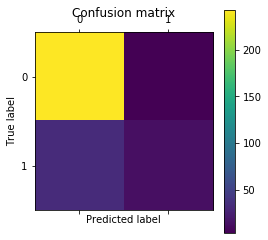

In [26]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_predictions)

print(cm)

# Show confusion matrix in a separate window
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [29]:
# One Prediction
instance_num = 6
# Get the prediction for the first member of the test set and explain why model made that prediction
prediction_value = model.predict(x_test)[instance_num]

print("One Prediction: ")
print(prediction_value)

print("20 Predictions: ")
print(y_predictions[:20])

x_test.head(20)

One Prediction: 
0
20 Predictions: 
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]


,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
899,49,Travel_Rarely,1098,Research & Development,4,2,Medical,1,Male,85,...,3,3,1,23,2,4,1,0,0,0
610,27,Travel_Rarely,269,Research & Development,5,1,Technical Degree,3,Male,42,...,3,2,1,9,3,3,9,8,0,8
667,41,Travel_Rarely,1085,Research & Development,2,4,Life Sciences,2,Female,57,...,3,3,1,10,1,2,7,7,1,0
857,44,Travel_Rarely,1097,Research & Development,10,4,Life Sciences,3,Male,96,...,3,3,0,6,4,3,6,4,0,2
1063,29,Travel_Rarely,1246,Sales,19,3,Life Sciences,3,Male,77,...,3,3,2,10,3,3,10,7,0,4
1022,37,Non-Travel,1413,Research & Development,5,2,Technical Degree,3,Male,84,...,3,1,0,7,2,1,6,5,1,3
665,47,Travel_Rarely,1454,Sales,2,4,Life Sciences,4,Female,65,...,3,1,0,3,3,2,3,2,1,2
840,35,Travel_Rarely,982,Research & Development,1,4,Medical,4,Male,58,...,3,2,1,10,2,3,8,0,1,7
796,25,Travel_Rarely,1219,Research & Development,4,1,Technical Degree,4,Male,32,...,3,2,1,7,3,4,7,7,5,6
1221,45,Non-Travel,1238,Research & Development,1,1,Life Sciences,3,Male,74,...,4,4,1,25,3,2,23,15,14,4


In [30]:
y_test.head(5)

899     0
610     0
667     1
857     1
1063    0
Name: Attrition, dtype: int64